In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from scipy.stats import norm
from keras.models import load_model
import scipy.optimize as scpo

In [2]:
History = pd.read_csv('')
call_df = pd.read_csv('')
risk_free_asset = pd.read_csv('')

In [ ]:
call_df=call_df[(call_df['Date']=='3/24/2020')] # | (call_df['Date']=='3/26/2020') | (call_df['Date']=='9/9/2020') | (call_df['Date']=='2/8/2019')]

call_df=call_df[(call_df['nDiff']==8) ]# | (call_df['nDiff']==14) | (call_df['nDiff']==48)]

In [ ]:
#Clean the data and merge data.
n_timesteps = 1

padded = np.insert(risk_free_asset.Rate.values, 0, np.array([np.nan] * n_timesteps))
rolled = np.column_stack([np.roll(padded, i) for i in range(n_timesteps)])
rolled = rolled[~np.isnan(rolled).any(axis=1)]
rolled = np.column_stack((risk_free_asset.Date.values[n_timesteps - 1:], rolled))
price_history = pd.DataFrame(data=rolled)
joined =call_df.join(price_history.set_index(0), on='Date')

joined['r']=joined[1]
call_df=joined.drop(columns=[1,'LTP', 'Risk_free_rate'],axis=1)


#Creates the stock dynamics for the n_timesteps back.
underlying=History
n_timesteps = 30
padded = np.insert(underlying.Close.values, 0, np.array([np.nan] * n_timesteps))
rolled = np.column_stack([np.roll(padded, i) for i in range(n_timesteps)])
rolled = rolled[~np.isnan(rolled).any(axis=1)]
rolled = np.column_stack((underlying.Date.values[n_timesteps - 1:], rolled))
price_history = pd.DataFrame(data=rolled)
joined = call_df.join(price_history.set_index(0), on='Date')
call_df=joined
call_df = call_df.drop(columns=['Expiry'])
call_df = call_df.dropna().rename(columns={'Underlying Value':'Closing_price','Strike Price':'strike'})

# BS

In [ ]:
S_BS_R = pd.read_csv('./Merton-stock')
S_BS = pd.read_csv('./Merton-stock-GA')
BS = pd.read_csv('./BS-input-output')

# Merton

In [ ]:
S_M_R = pd.read_csv('./Merton-stock')
S_M = pd.read_csv('./Merton-stock-GA')
M = pd.read_csv('./Merton-input-output')

# Heston

In [ ]:
S_H_R = pd.read_csv('./Heston-stock')
S_H = pd.read_csv('./Heston-stock-GA')
H = pd.read_csv('./Heston-input-output')

# Bates

In [ ]:
S_B_R = pd.read_csv('./Bates-stock')
S_B = pd.read_csv('./Bates-stock-GA')
B = pd.read_csv('./Bates-input-output')

# LSTM

In [64]:
LSTM = pd.read_csv('./LSTM-STOCK.csv')
lstm_model = load_model('../saved-models/call-lstm.h5')

data_reshaped=list([call_df.drop(columns=['Close'],axis=1)[np.arange(1,n_timesteps +1)].values.reshape(len(call_df),n_timesteps,1).astype(np.float64),
call_df.drop(columns=['Close'],axis=1)[['strike','nDiff', 'Closing_price','r']].values.astype(np.float64)]) #reform

call_df['lstm']=lstm_model.predict(data_reshaped)

# CNN

In [65]:
CNN = pd.read_csv('./CNN-STOCK_V2.csv')
cnn_model = load_model('.call-cnn.h5') #Load our trained CNN

call_df['cnn']=cnn_model.predict(data_reshaped)

## MLP

In [66]:
MLP = pd.read_csv('./MLP-STOCK.csv')
mlp_model = load_model('./call-mlp.h5') #Load our trained MLP

call_df['mlp']=cnn_model.predict(data_reshaped)

# Log-returns

C:\Users\emil-\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\emil-\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\emil-\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdep

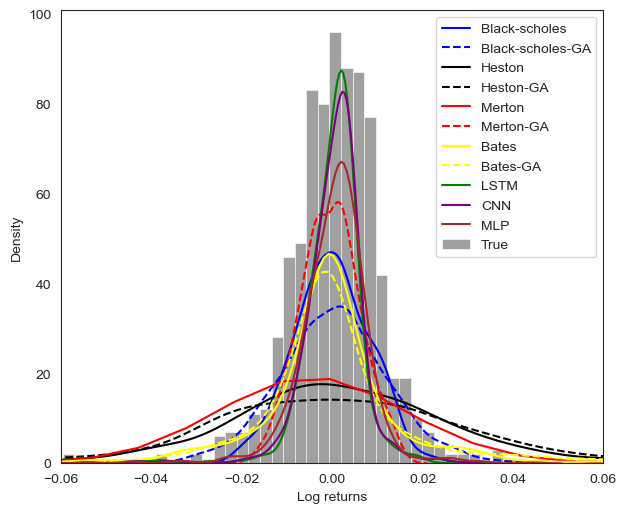

In [38]:
with PdfPages(r'Log-returns.pdf') as export_pdf:
    sns.set_style("white")
    sns.color_palette("rocket")
    f,ax=plt.subplots(figsize=(7,6), dpi=100)
    sns.distplot(np.diff(np.log(S_BS_R)), color="blue",hist=False,label='Black-scholes')
    sns.distplot(np.diff(np.log(S_BS)), color="blue",hist=False,label='Black-scholes-GA',kde_kws={'linestyle':'--'})
    sns.histplot(np.diff(np.log(History.Close.values)), color="grey",label='True')
    sns.distplot(np.diff(np.log(S_H_R)), color="black",hist=False,label='Heston')  
    sns.distplot(np.diff(np.log(S_H)), color="black",hist=False,label='Heston-GA',kde_kws={'linestyle':'--'})
    sns.distplot(np.diff(np.log(S_M_R)), color="red",hist=False,label='Merton')
    sns.distplot(np.diff(np.log(S_M)), color="red",hist=False,label='Merton-GA',kde_kws={'linestyle':'--'})
    sns.distplot(np.diff(np.log(S_B_R)), color="yellow",hist=False,label='Bates')
    sns.distplot(np.diff(np.log(S_B)), color="yellow",hist=False,label='Bates-GA',kde_kws={'linestyle':'--'})
    sns.distplot(np.diff(np.log(LSTM.Predictions)), color="green",hist=False,label='LSTM')
    sns.distplot(np.diff(np.log(CNN.Predictions)), color="purple",hist=False,label='CNN')
    sns.distplot(np.diff(np.log(MLP.Predictions)), color="brown",hist=False,label='MLP')


    ax.legend()
    ax.set_xlim(-0.06,0.06)
    ax.set(xlabel='Log returns')
    export_pdf.savefig()

In [45]:
def SSR(y):
    x=np.diff(np.log(History.Close.values)) ## Actual value
    return np.sum(np.square(x-y))

In [73]:
SSRs=[
SSR(np.diff(np.log(S_BS_R))),
SSR(np.diff(np.log(S_BS))),
SSR(np.diff(np.log(S_M_R))),
SSR(np.diff(np.log(S_M))),
SSR(np.diff(np.log(S_H_R))),
SSR(np.diff(np.log(S_H))),
SSR(np.diff(np.log(S_B_R))),
SSR(np.diff(np.log(S_B))),
SSR(np.diff(np.log(LSTM.Predictions))),
SSR(np.diff(np.log(CNN.Predictions))),
SSR(np.diff(np.log(MLP.Predictions)))]

In [83]:
print('BS: {:.3f} & BS1: {:.3f} & Merton: {:.3f} & Merton1: {:.3f} & Heston: {:.3f} & Heston1: {:.3f} & Bates: {:.3f} & Bates1: {:.3f} & LSTM: {:.3f} & CNN: {:.3f} & MLP: {:.3f} '.format(*SSRs))

BS: 0.197 & BS1: 0.274 & Merton: 0.633 & Merton1: 0.736 & Heston: 4.169 & Heston1: 0.184 & Bates: 2.419 & Bates1: 1.118 & LSTM: 0.175 & CNN: 0.18 & MLP: 0.208 


# IV

In [ ]:
def implied_volatility(row):
    S = row.Closing_price
    price=row.BS #Change to correct model
    X = row.strike
    T = row.nDiff / 365
    r = row.r / 100
    
    def obj_fun(σ):
            d1 = (np.log(S / X) + (r + (σ ** 2) / 2) * T) / (σ * (T ** .5))
            d2 = d1 - σ * (T ** .5)
            C = S * norm.cdf(d1) - X * np.exp(-r * T) * norm.cdf(d2)
            return ( C-price)**2
    
    res = scpo.minimize_scalar( obj_fun, bounds=(1e-15, 8), method='bounded')
    if res.success == True:
        return res.x

In [ ]:
call_df['BS-IV'] = call_df.apply(implied_volatility, axis=1) # Change previous def and run the two sections again for each model.

In [ ]:

fig = plt.figure(figsize=(16,4))
plt.plot(call_df.strike,call_df.IV, label='Actual')
plt.plot(call_df.strike, call_df['BS-IV'], label='BS')
plt.plot(call_df.strike,call_df['BS-IV-GA'], label='BS GA')
plt.plot(call_df.strike, call_df['M-IV'], label='Merton')
plt.plot(call_df.strike,call_df['M-IV-GA'], label='Merton GA')
plt.plot(call_df.strike, call_df['H-IV'], label='Heston')
plt.plot(call_df.strike,call_df['H-IV-GA'], label='Heston GA')
plt.plot(call_df.strike, call_df['B-IV'], label='Bates')
plt.plot(call_df.strike,call_df['B-IV-GA'], label='Bates GA')
plt.plot(call_df.strike, call_df['LSTM-IV'], label='LSTM')
plt.plot(call_df.strike,call_df['CNN-IV'], label='CNN')
plt.plot(call_df.strike, call_df['MLP-IV'], label='MLP')